<a href="https://colab.research.google.com/github/maz-joko78/VTCI-LANDSAT-LC08-C02-T1_L2/blob/main/Calculate_VTCI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
pip install numpy rasterio matplotlib

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Nilai sebelum masking LST awal:
Nilai maksimum LST: 73.51
Nilai minimum LST: 4.06
Nilai maksimum NDVI: 1.00
Nilai minimum NDVI: -1.00

Nilai setelah masking LST awal:
Nilai maksimum LST: 73.51
Nilai minimum LST: 4.06

Jumlah piksel valid setelah masking: 21546774

Jumlah piksel setelah filtering outlier: 21281892

Jumlah bin valid untuk regresi: 50
Slope cold edge (-3.7329) negatif. Mengubahnya menjadi 3.7329.
Warm edge (tepi panas): LST = -15.5778 * NDVI + 54.5029
Cold edge (tepi dingin): LST = 3.7329 * NDVI + 25.5916

VTCI calculation complete.
AOI file loaded from: /content/drive/MyDrive/Data_2022/NTB.shp


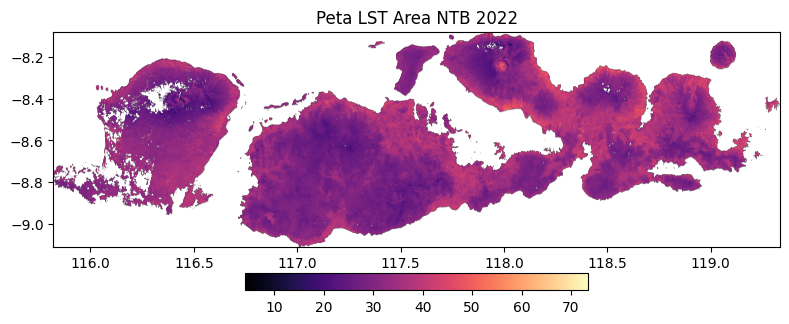

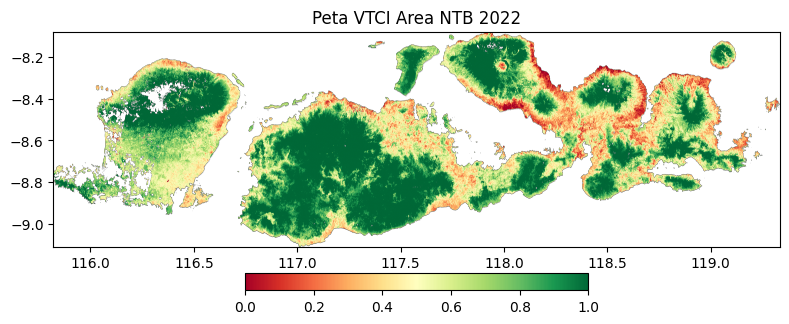


Rentang visualisasi NDVI (2%-98% data valid): 0.32 - 0.90


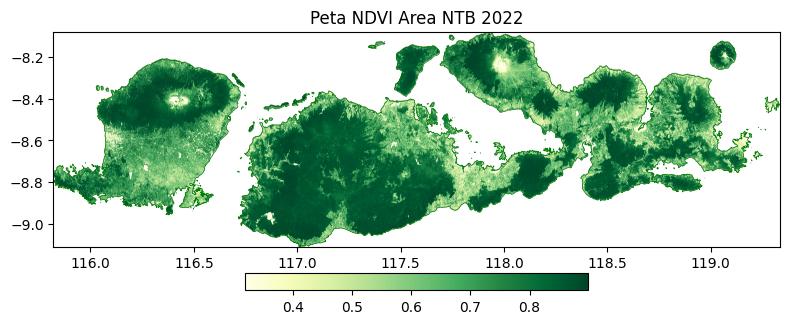

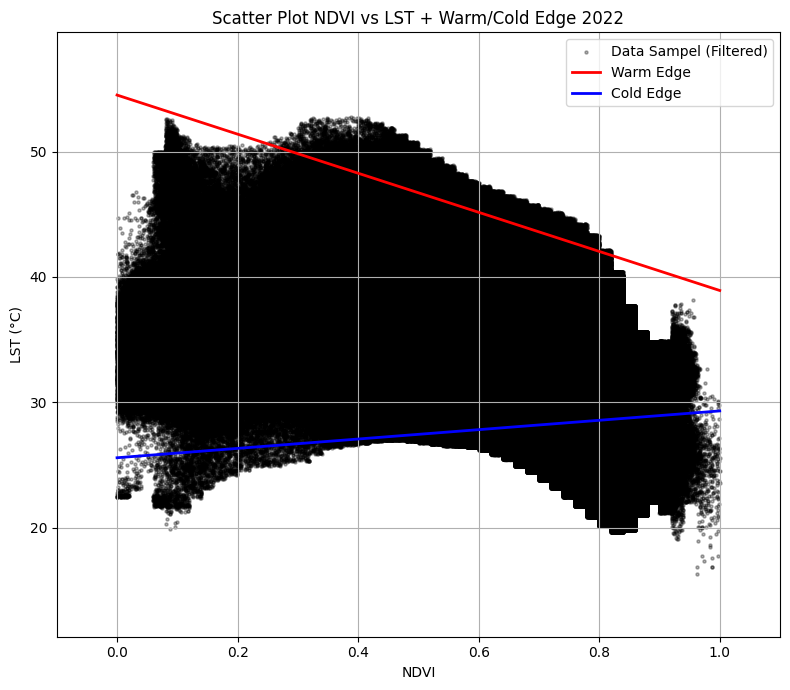

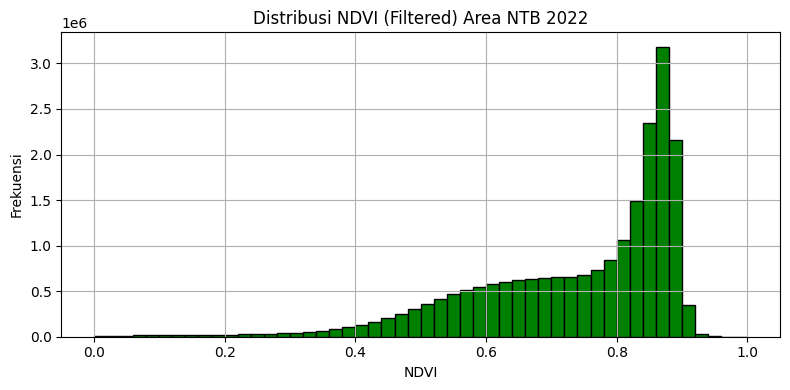


Raster VTCI berhasil diekspor ke: /content/drive/MyDrive/Data_2022/Hasil_VTCI/VTCI2022_output.tif
Grafik peta LST berhasil diekspor ke: /content/drive/MyDrive/Data_2022/Hasil_VTCI/LST2022_Map.png
Grafik peta VTCI berhasil diekspor ke: /content/drive/MyDrive/Data_2022/Hasil_VTCI/VTCI2022_Map.png
Grafik peta NDVI berhasil diekspor ke: /content/drive/MyDrive/Data_2022/Hasil_VTCI/NDVI2022_Map.png
Grafik scatter plot berhasil diekspor ke: /content/drive/MyDrive/Data_2022/Hasil_VTCI/NDVI_LST_ScatterPlot2022.png
Grafik histogram berhasil diekspor ke: /content/drive/MyDrive/Data_2022/Hasil_VTCI/NDVI_Filtered_Histogram2022.png
Koefisien regresi berhasil diekspor ke: /content/drive/MyDrive/Data_2022/Hasil_VTCI/regression_coefficients2022.txt
Data LST dan NDVI yang difilter berhasil diekspor ke: /content/drive/MyDrive/Data_2022/Hasil_VTCI/filtered_data2022.csv


In [3]:
# Import pustaka yang dibutuhkan
from IPython import get_ipython
from IPython.display import display
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import os
from google.colab import drive # Untuk mounting Google Drive
import geopandas as gpd # Import geopandas

# =============================
# Langkah Setup Awal
# =============================
# Tujuan: Memasang Google Drive agar dapat mengakses file data.
# Anda akan diminta otorisasi, ikuti langkah-langkahnya
drive.mount('/content/drive')

# =============================
# 1. Load Data LST dan NDVI & Initial Masking
# =============================
# Tujuan: Membaca data citra LST dan NDVI, dan menerapkan masking awal
lst_path = '/content/drive/MyDrive/Data_2022/LST2022.tif'
ndvi_path = '/content/drive/MyDrive/Data_2022/NDVI2022.tif'

# Pengecekan file (opsional)
if not os.path.exists(lst_path):
    print(f"Error: File LST tidak ditemukan di {lst_path}")
    # exit() # Hentikan jika file tidak ada - Ganti dengan raise
    raise FileNotFoundError(f"File LST tidak ditemukan di {lst_path}")
if not os.path.exists(ndvi_path):
    print(f"Error: File NDVI tidak ditemukan di {ndvi_path}")
    # exit() # Hentikan jika file tidak ada - Ganti dengan raise
    raise FileNotFoundError(f"File NDVI tidak ditemukan di {ndvi_path}")

try:
    with rasterio.open(lst_path) as src:
        lst_full = src.read(1) # Simpan data asli dengan nama berbeda
        lst_meta = src.meta
        # Ambil extent dari LST untuk visualisasi nanti
        extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]


    with rasterio.open(ndvi_path) as src:
        ndvi_full = src.read(1) # Simpan data asli dengan nama berbeda

except rasterio.errors.RasterioIOError as e:
    print(f"Gagal membuka file raster: {e}")
    print("Pastikan Google Drive ter-mount dan path file benar.")
    # exit() # Hentikan jika gagal membuka file - Ganti dengan raise
    raise e


# Tampilkan nilai min/max sebelum masking (opsional)
print("Nilai sebelum masking LST awal:")
print(f"Nilai maksimum LST: {np.nanmax(lst_full):.2f}")
print(f"Nilai minimum LST: {np.nanmin(lst_full):.2f}")
print(f"Nilai maksimum NDVI: {np.nanmax(ndvi_full):.2f}")
print(f"Nilai minimum NDVI: {np.nanmin(ndvi_full):.2f}")

# --- Masking LST berdasarkan rentang nilai realistis (0 < LST < LST_max) ---
# Buat mask untuk nilai LST yang berada dalam rentang [0, ]
# Perhatian: Mungkin perlu disesuaikan dengan rentang LST yang wajar untuk area studi
lst_range_mask = (lst_full >= 0) & (~np.isnan(lst_full))

# Terapkan mask pada data LST_full
# Nilai LST di luar rentang akan diubah menjadi NaN
lst_full_masked_initial = lst_full.copy() # Buat salinan agar data asli utuh jika perlu
lst_full_masked_initial[~lst_range_mask] = np.nan

print("\nNilai setelah masking LST awal:")
print(f"Nilai maksimum LST: {np.nanmax(lst_full_masked_initial):.2f}")
print(f"Nilai minimum LST: {np.nanmin(lst_full_masked_initial):.2f}")


# =============================
# 2. Mask Data Non-Valid (NaN di LST atau NDVI)
# =============================
# Tujuan: Menghapus piksel yang memiliki nilai NaN (termasuk yang baru saja
# dibuat dari masking LST) di salah satu atau kedua band LST dan NDVI
# untuk analisis regresi selanjutnya.
if lst_full_masked_initial.shape != ndvi_full.shape:
    print("Error: Dimensi LST dan NDVI tidak sama.")
    # exit() # Ganti dengan raise
    raise ValueError("Dimensi LST dan NDVI tidak sama.")

# Buat mask untuk piksel yang valid (bukan NaN di kedua band)
# Mask ini sekarang juga memperhitungkan piksel yang diubah menjadi NaN
# pada langkah masking LST awal.
mask = np.logical_and(~np.isnan(lst_full_masked_initial), ~np.isnan(ndvi_full))

# Flatten data dan terapkan mask untuk mendapatkan array 1D dari piksel valid
lst_masked_flat = lst_full_masked_initial[mask]
ndvi_masked_flat = ndvi_full[mask]

print(f"\nJumlah piksel valid setelah masking: {len(lst_masked_flat)}")

if len(lst_masked_flat) == 0:
    print("Error: Tidak ada piksel valid yang tersisa setelah masking.")
    raise ValueError("Tidak ada piksel valid yang tersisa setelah masking.")


# =============================
# 3. Binning NDVI dan Filter Outlier LST
# =============================
# Tujuan: Membagi data ke dalam bin NDVI (menggunakan data masked) dan menghapus
# nilai LST yang dianggap outlier dalam setiap bin untuk mendapatkan data
# yang lebih bersih untuk regresi warm/cold edge.
bin_edges = np.arange(0, 1.01, 0.02) # Asumsi NDVI antara 0 dan 1
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

lst_filtered_list = [] # Gunakan list sementara
ndvi_filtered_list = [] # Gunakan list sementara

# Iterasi melalui setiap bin NDVI menggunakan data yang sudah di-masking
for i in range(len(bin_edges) - 1):
    # Mask untuk piksel dalam bin NDVI saat ini
    bin_mask = np.logical_and(ndvi_masked_flat >= bin_edges[i], ndvi_masked_flat < bin_edges[i+1])
    lst_bin = lst_masked_flat[bin_mask]
    ndvi_bin = ndvi_masked_flat[bin_mask]

    # Hanya proses bin dengan cukup data
    # Menambah jumlah minimum data untuk outlier filtering
    if len(lst_bin) > 20: # Ambang batas disesuaikan menjadi 20
        # Hitung statistik dan tentukan ambang outlier (menggunakan IQR atau STD)
        # Menggunakan metode STD (sesuai kode asli)
        median = np.median(lst_bin)
        std = np.std(lst_bin)

        # Menyesuaikan faktor pengali STD
        # Menggunakan 2.0 atau 1.5 STD bisa lebih baik daripada 2.5 atau 3.0 untuk outlier removal yang lebih ketat
        lower = median - 3.0 * std # Faktor pengali disesuaikan
        upper = median + 3.0 * std # Faktor pengali disesuaikan

        # Mask untuk inlier (bukan outlier) dalam bin LST
        inlier_mask = np.logical_and(lst_bin >= lower, lst_bin <= upper)

        # Tambahkan inlier ke list sementara
        lst_filtered_list.append(lst_bin[inlier_mask])
        ndvi_filtered_list.append(ndvi_bin[inlier_mask])

# Gabungkan hasil filtering dari semua bin menjadi array tunggal
if lst_filtered_list and ndvi_filtered_list:
    lst_filtered = np.concatenate(lst_filtered_list)
    ndvi_filtered = np.concatenate(ndvi_filtered_list)
    print(f"\nJumlah piksel setelah filtering outlier: {len(lst_filtered)}")
else:
    print("Error: Tidak ada data yang tersisa setelah binning dan filtering outlier.")
    # exit() # Ganti dengan raise
    raise ValueError("Tidak ada data yang tersisa setelah binning dan filtering outlier.")


# =============================
# 4. Identifikasi dan Regresi Warm/Cold Edge
# =============================
# Tujuan: Menemukan nilai LST maksimum (warm edge) dan minimum (cold edge)
# untuk setiap bin NDVI (menggunakan data filtered) dan melakukan regresi
# linier untuk mendapatkan persamaan garis warm/cold edge.
max_lst_per_bin = []
min_lst_per_bin = []
valid_bin_centers = [] # Gunakan list sementara untuk center bin yang valid

# Iterasi melalui bin NDVI menggunakan data yang sudah difilter
for i in range(len(bin_edges) - 1):
    # Mask untuk piksel dalam bin NDVI saat ini (menggunakan data yang difilter)
    bin_mask = np.logical_and(ndvi_filtered >= bin_edges[i], ndvi_filtered < bin_edges[i+1])
    lst_bin = lst_filtered[bin_mask]

    # Hanya proses bin dengan data yang cukup untuk mencari max/min
    if len(lst_bin) > 0:
        max_lst_per_bin.append(np.max(lst_bin))
        min_lst_per_bin.append(np.min(lst_bin))
        # Tambahkan center dari bin yang valid ke list
        valid_bin_centers.append(bin_centers[i])

print(f"\nJumlah bin valid untuk regresi: {len(valid_bin_centers)}")

# Pastikan ada cukup titik (bin) untuk regresi (minimal 2 titik)
if len(valid_bin_centers) < 2:
     print("Error: Tidak cukup bin yang valid untuk melakukan regresi. Diperlukan minimal 2 bin.")
     # exit() # Ganti dengan raise
     raise ValueError("Tidak cukup bin yang valid untuk melakukan regresi.")

# Ubah list menjadi array NumPy dan reshape untuk model regresi
# Perbaikan: Mengubah reshape(0, 1) menjadi reshape(-1, 1)
valid_bin_centers_array = np.array(valid_bin_centers).reshape(-1, 1)
max_lst_per_bin_array = np.array(max_lst_per_bin)
min_lst_per_bin_array = np.array(min_lst_per_bin)


# Lakukan regresi linier untuk warm edge (LST maksimum vs NDVI bin center)
warm_model = LinearRegression().fit(valid_bin_centers_array, max_lst_per_bin_array)
warm_a, warm_b = warm_model.coef_[0], warm_model.intercept_

# Lakukan regresi linier untuk cold edge (LST minimum vs NDVI bin center)
cold_model = LinearRegression().fit(valid_bin_centers_array, min_lst_per_bin_array)
cold_a, cold_b = cold_model.coef_[0], cold_model.intercept_

# --- Penyesuaian Cold Edge Slope ---
# Jika slope cold edge negatif, kalikan dengan -1 (ambil nilai absolut)
if cold_a < 0:
    print(f"Slope cold edge ({cold_a:.4f}) negatif. Mengubahnya menjadi {abs(cold_a):.4f}.")
    cold_a = abs(cold_a) # Mengalikan dengan -1 sama dengan mengambil nilai absolutnya

#if cold_a < 0:
    #print(f"Slope cold edge ({cold_a:.4f}) negatif.")
#    cold_a = 0.5

print(f"Warm edge (tepi panas): LST = {warm_a:.4f} * NDVI + {warm_b:.4f}")
print(f"Cold edge (tepi dingin): LST = {cold_a:.4f} * NDVI + {cold_b:.4f}")

# =============================
# 5. Hitung VTCI Spasial
# =============================
# Tujuan: Menggunakan persamaan warm/cold edge untuk menghitung nilai VTCI
# untuk setiap piksel dalam citra asli (termasuk piksel yang sebelumnya
# Hitung LST maksimum (warm edge) dan minimum (cold edge) untuk setiap piksel
# berdasarkan nilai NDVI piksel tersebut menggunakan persamaan regresi.
# Gunakan ndvi_full di sini karena perhitungan dilakukan untuk seluruh piksel spasial
# Mask lst_full_masked_initial untuk perhitungan agar konsisten dengan data regresi
lst_calc = lst_full_masked_initial.copy()
ndvi_calc = ndvi_full.copy() # Gunakan ndvi_full asli untuk perhitungan

# Hitung predicted LST_max dan LST_min untuk semua piksel
lst_max_predicted = warm_a * ndvi_calc + warm_b
lst_min_predicted = cold_a * ndvi_calc + cold_b

# Hitung denominator (LST_max - LST_min)
denominator = lst_max_predicted - lst_min_predicted

# Inisialisasi array VTCI dengan NaN
vtci = np.full(lst_calc.shape, np.nan, dtype=np.float32)

# Buat mask untuk piksel yang valid untuk perhitungan VTCI:
# 1. Bukan NaN di LST atau NDVI (sudah diatasi oleh lst_full_masked_initial)
# 2. Denominator tidak mendekati nol
# 3. LST_max_predicted harus lebih besar dari LST_min_predicted (untuk menghindari pembagian negatif)
#    Meskipun clipping [0, 1] akan menangani nilai di luar rentang, pembagian negatif
#    menunjukkan masalah fisik, jadi sebaiknya di-mask.
valid_vtci_mask = ~np.isnan(lst_calc) & ~np.isnan(ndvi_calc)
valid_vtci_mask &= (np.abs(denominator) > 1e-6) # Hindari pembagian dengan nilai mendekati nol
valid_vtci_mask &= (lst_max_predicted > lst_min_predicted) # LSTmax harus lebih besar dari LSTmin

# Hitung VTCI hanya untuk piksel yang valid
numerator_valid = lst_max_predicted[valid_vtci_mask] - lst_calc[valid_vtci_mask]
denominator_valid = denominator[valid_vtci_mask]

vtci[valid_vtci_mask] = numerator_valid / denominator_valid

# Pastikan nilai VTCI berada dalam rentang [0, 1]
vtci = np.clip(vtci, 0, 1)

# Atur nodata value jika diperlukan
output_nodata = -9999
vtci[np.isnan(vtci)] = output_nodata
output_meta_vtci = lst_meta.copy()
output_meta_vtci.update({'dtype': 'float32', 'nodata': output_nodata})

print("\nVTCI calculation complete.")

# =============================
# 6. Visualisasi dengan Masking, Koordinat Spasial, dan AOI
# =============================
# Tujuan: Menampilkan citra LST (setelah masking awal 0-70) dan citra VTCI
# dengan mempertimbangkan extent spasial dan overlay AOI.

# --- Add AOI File Path ---
aoi_path = '/content/drive/MyDrive/Data_2022/NTB.shp' # <-- Ganti dengan path file AOI Anda
aoi_gdf = None # Inisialisasi AOI GeoDataFrame

# Coba muat AOI
try:
    aoi_gdf = gpd.read_file(aoi_path)
    print(f"AOI file loaded from: {aoi_path}")

    # Periksa CRS dan reproyeksi jika perlu
    try:
         with rasterio.open(lst_path) as src_crs:
              raster_crs = src_crs.crs
    except rasterio.errors.RasterioIOError:
         raster_crs = None
         print("Warning: Could not open LST file to get CRS for AOI reprojection.")

    if raster_crs and aoi_gdf.crs != raster_crs:
        print(f"Reprojecting AOI from {aoi_gdf.crs} to {raster_crs}")
        aoi_gdf = aoi_gdf.to_crs(raster_crs)
    elif not raster_crs:
        print("Warning: Raster CRS unknown, skipping AOI reprojection check.")

except Exception as e:
    print(f"Error loading AOI file: {e}")
    print(f"Please check if the AOI path '{aoi_path}' is correct and if the file exists.")
    aoi_gdf = None # Set aoi_gdf ke None jika gagal dimuat


# --- Plot 1: LST (Single Plot) ---
fig_lst, ax_lst = plt.subplots(1, 1, figsize=(8, 8))
# Gunakan lst_full_masked_initial untuk visualisasi
masked_lst_viz = np.ma.masked_invalid(lst_full_masked_initial)
# Ganti 'Inferno' dengan colormap yang valid, contoh 'hot'
im_lst = ax_lst.imshow(masked_lst_viz, cmap='magma', extent=extent)
ax_lst.set_title('Peta LST Area NTB 2022')
# Kurangi ketebalan colorbar LST menjadi setengah
fig_lst.colorbar(im_lst, ax=ax_lst, orientation='horizontal', fraction=0.023, pad=0.035)
if aoi_gdf is not None:
    aoi_gdf.plot(ax=ax_lst, facecolor='none', edgecolor='black', linewidth=0.05)
plt.tight_layout()
plt.show()

# --- Plot 2: VTCI (Single Plot) ---
fig_vtci, ax_vtci = plt.subplots(1, 1, figsize=(8, 8))
# Gunakan array VTCI yang sudah dihitung
# Masking berdasarkan nilai nodata yang ditentukan
masked_vtci_viz = np.ma.masked_where(vtci == output_nodata, vtci)
im_vtci = ax_vtci.imshow(masked_vtci_viz, cmap='RdYlGn', extent=extent, vmin=0, vmax=1)
ax_vtci.set_title('Peta VTCI Area NTB 2022')
# Kurangi ketebalan colorbar VTCI menjadi setengah
fig_vtci.colorbar(im_vtci, ax=ax_vtci, orientation='horizontal', fraction=0.023, pad=0.035)
if aoi_gdf is not None:
    aoi_gdf.plot(ax=ax_vtci, facecolor='none', edgecolor='black', linewidth=0.05)
plt.tight_layout()
plt.show()

# --- Plot 3: NDVI (Single Plot) ---
fig_ndvi, ax_ndvi = plt.subplots(1, 1, figsize=(8, 8))
# Gunakan ndvi_full asli untuk visualisasi, masked dengan NaN
masked_ndvi_viz = np.ma.masked_invalid(ndvi_full)

# Tentukan rentang visualisasi NDVI (misal 2% - 98% dari data valid)
valid_ndvi_viz_vals = ndvi_full[~np.isnan(ndvi_full)]
if len(valid_ndvi_viz_vals) > 0:
    ndvi_vmin_viz = np.percentile(valid_ndvi_viz_vals, 2)
    ndvi_vmax_viz = np.percentile(valid_ndvi_viz_vals, 98)
    # Pastikan rentang visualisasi tetap dalam [-1, 1]
    ndvi_vmin_viz = max(ndvi_vmin_viz, -1.0)
    ndvi_vmax_viz = min(ndvi_vmax_viz, 1.0)
    print(f"\nRentang visualisasi NDVI (2%-98% data valid): {ndvi_vmin_viz:.2f} - {ndvi_vmax_viz:.2f}")
else:
    ndvi_vmin_viz = -1.0
    ndvi_vmax_viz = 1.0
    print("\nTidak ada data NDVI valid ditemukan untuk menentukan rentang visualisasi. Menggunakan rentang default [-1, 1].")


im_ndvi = ax_ndvi.imshow(masked_ndvi_viz, cmap='YlGn', extent=extent, vmin=ndvi_vmin_viz, vmax=ndvi_vmax_viz)
ax_ndvi.set_title('Peta NDVI Area NTB 2022')
# Kurangi ketebalan colorbar NDVI menjadi setengah
fig_ndvi.colorbar(im_ndvi, ax=ax_ndvi, orientation='horizontal', fraction=0.023, pad=0.035)
if aoi_gdf is not None:
    aoi_gdf.plot(ax=ax_ndvi, facecolor='none', edgecolor='green', linewidth=0.5)
plt.tight_layout()
plt.show()


# =============================
# 7. Scatter Plot NDVI vs LST + Regresi
# =============================
# Tujuan: Memvisualisasikan data titik LST vs NDVI yang telah difilter
# beserta garis regresi warm dan cold edge.
fig_scatter, ax_scatter = plt.subplots(figsize=(8, 7)) # Ukuran figure disesuaikan

# Scatter plot data yang sudah difilter (dari langkah 3)
ax_scatter.scatter(ndvi_filtered, lst_filtered, s=5, c='black', alpha=0.3, label='Data Sampel (Filtered)') # s disesuaikan, alpha ditambah

# Buat rentang nilai NDVI untuk garis regresi
# Gunakan rentang dari 0 hingga 1 untuk menunjukkan garis di seluruh rentang NDVI
ndvi_line = np.linspace(0, 1, 100)

# Plot garis warm edge
ax_scatter.plot(ndvi_line, warm_a * ndvi_line + warm_b, 'r-', label='Warm Edge', linewidth=2) # linewidth ditambah

# Plot garis cold edge
ax_scatter.plot(ndvi_line, cold_a * ndvi_line + cold_b, 'b-', label='Cold Edge', linewidth=2) # linewidth ditambah

ax_scatter.set_xlabel('NDVI')
ax_scatter.set_ylabel('LST (°C)')
ax_scatter.set_title('Scatter Plot NDVI vs LST + Warm/Cold Edge 2022')
ax_scatter.grid(True)
# Lokasi legenda disesuaikan agar tidak menutupi plot
ax_scatter.legend(loc='upper right')

# Atur batas sumbu X dan Y agar lebih rapi
ax_scatter.set_xlim([-0.1, 1.1]) # Batas NDVI diperluas sedikit
# Batas LST bisa diatur berdasarkan min/max data atau warm/cold edge pada NDVI=0 dan NDVI=1
min_lst_plot = min(np.min(lst_filtered), cold_b, warm_a * 1 + warm_b, cold_a * 1 + cold_b)
max_lst_plot = max(np.max(lst_filtered), warm_b, warm_a * 1 + warm_b, cold_a * 1 + cold_b)
ax_scatter.set_ylim([min_lst_plot - 5, max_lst_plot + 5]) # Batas LST diberi margin

plt.tight_layout()
plt.show()

# Optional: Plot histogram of filtered NDVI data to check distribution
# Simpan referensi ke figure histogram jika ingin disimpan
fig_hist, ax_hist = plt.subplots(figsize=(8, 4))
ax_hist.hist(ndvi_filtered, bins=50, color='green', edgecolor='black')
ax_hist.set_title('Distribusi NDVI (Filtered) Area NTB 2022')
ax_hist.set_xlabel('NDVI')
ax_hist.set_ylabel('Frekuensi')
ax_hist.grid(True)
plt.tight_layout()
plt.show()


# =============================
# 8. Ekspor Hasil ke Google Drive
# =============================

output_dir = '/content/drive/MyDrive/Data_2022/Hasil_VTCI/' # Ganti dengan folder target di Google Drive Anda
os.makedirs(output_dir, exist_ok=True)

output_vtci_raster_path = os.path.join(output_dir, 'VTCI2022_output.tif')
output_lst_plot_path = os.path.join(output_dir, 'LST2022_Map.png')
output_vtci_plot_path = os.path.join(output_dir, 'VTCI2022_Map.png')
output_ndvi_plot_path = os.path.join(output_dir, 'NDVI2022_Map.png')
output_scatter_plot_path = os.path.join(output_dir, 'NDVI_LST_ScatterPlot2022.png')
output_histogram_plot_path = os.path.join(output_dir, 'NDVI_Filtered_Histogram2022.png')
output_regression_coeffs_path = os.path.join(output_dir, 'regression_coefficients2022.txt')
output_filtered_data_path = os.path.join(output_dir, 'filtered_data2022.csv')


# 8.1 Ekspor Raster VTCI ke GeoTIFF
try:
    # Gunakan metadata yang sudah diperbarui dengan nodata VTCI
    with rasterio.open(output_vtci_raster_path, 'w', **output_meta_vtci) as dst:
        dst.write(vtci, 1) # Menulis band pertama
    print(f"\nRaster VTCI berhasil diekspor ke: {output_vtci_raster_path}")
except Exception as e:
    print(f"\nGagal mengekspor raster VTCI: {e}")


# 8.2 Ekspor Grafik ke File Gambar
try:
    fig_lst.savefig(output_lst_plot_path, dpi=300, bbox_inches='tight')
    print(f"Grafik peta LST berhasil diekspor ke: {output_lst_plot_path}")
except Exception as e:
     print(f"Gagal mengekspor grafik peta LST: {e}")

try:
    fig_vtci.savefig(output_vtci_plot_path, dpi=300, bbox_inches='tight')
    print(f"Grafik peta VTCI berhasil diekspor ke: {output_vtci_plot_path}")
except Exception as e:
     print(f"Gagal mengekspor grafik peta VTCI: {e}")

try:
    fig_ndvi.savefig(output_ndvi_plot_path, dpi=300, bbox_inches='tight')
    print(f"Grafik peta NDVI berhasil diekspor ke: {output_ndvi_plot_path}")
except Exception as e:
     print(f"Gagal mengekspor grafik peta NDVI: {e}")

try:
    fig_scatter.savefig(output_scatter_plot_path, dpi=300, bbox_inches='tight')
    print(f"Grafik scatter plot berhasil diekspor ke: {output_scatter_plot_path}")
except Exception as e:
     print(f"Gagal mengekspor grafik scatter plot: {e}")

if 'fig_hist' in locals() and fig_hist is not None:
    try:
        fig_hist.savefig(output_histogram_plot_path, dpi=300, bbox_inches='tight')
        print(f"Grafik histogram berhasil diekspor ke: {output_histogram_plot_path}")
    except Exception as e:
         print(f"Gagal mengekspor grafik histogram: {e}")

# Tutup figure untuk menghemat memori
plt.close(fig_lst)
plt.close(fig_vtci)
plt.close(fig_ndvi)
plt.close(fig_scatter)
if 'fig_hist' in locals() and fig_hist is not None:
    plt.close(fig_hist)

# 8.3 Ekspor Data Lainnya (Opsional)
try:
    with open(output_regression_coeffs_path, 'w') as f:
        f.write("Koefisien Regresi:\n")
        f.write(f"Warm edge (LSTmax): LST = {warm_a:.4f} * NDVI + {warm_b:.4f}\n")
        f.write(f"Cold edge (LSTmin): LST = {cold_a:.4f} * NDVI + {cold_b:.4f}\n")
    print(f"Koefisien regresi berhasil diekspor ke: {output_regression_coeffs_path}")
except Exception as e:
    print(f"Gagal mengekspor koefisien regresi: {e}")

try:
    # Siapkan data untuk diekspor
    # Periksa apakah ndvi_filtered dan lst_filtered ada dan memiliki panjang yang sama
    if 'ndvi_filtered' in locals() and 'lst_filtered' in locals() and len(ndvi_filtered) == len(lst_filtered) and len(ndvi_filtered) > 0:
        filtered_data = np.vstack((ndvi_filtered, lst_filtered)).T
        np.savetxt(output_filtered_data_path, filtered_data, delimiter=',', header='NDVI_Filtered,LST_Filtered', comments='')
        print(f"Data LST dan NDVI yang difilter berhasil diekspor ke: {output_filtered_data_path}")
    else:
        print("Data filtered (ndvi_filtered, lst_filtered) kosong atau tidak konsisten. Tidak bisa mengekspor filtered_data.csv")
except Exception as e:
    print(f"Gagal mengekspor data yang difilter: {e}")